### Importing Libraries

In [2]:
#import dependencies
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy
import re

#sentiment analysis
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

#keyword Extraction
from sklearn.feature_extraction.text import TfidfVectorizer


#visuals
import matplotlib.pyplot as plt
from wordcloud import WordCloud

### Load bank_reviews dataset 

In [4]:
df = pd.read_csv('bank_reviews.csv')
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'bank_reviews.csv'

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6670 entries, 0 to 6669
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  6669 non-null   object
 1   rating  6670 non-null   int64 
 2   date    6670 non-null   object
 3   bank    6670 non-null   object
 4   source  6670 non-null   object
dtypes: int64(1), object(4)
memory usage: 260.7+ KB


In [4]:
df['review']

0            the app is proactive and a good connections.
1         I cannot send to cbebirr app. through this app.
2                                                    good
3                                          not functional
4       everytime you uninstall the app you have to re...
                              ...                        
6665                                            Nice one.
6666                           በጣም ደስ የሚል ለውጥ አናመሰግናለን 🇪🇹
6667         Best application👍Thank you ! Abyssinia bank.
6668    Absolutely it's fantastic apps this New apps i...
6669           The best app next to Tele birr in ethiopia
Name: review, Length: 6670, dtype: object

### Preprocessing the Data¶
Steps:

1. Clean text: Remove punctuation, special characters, convert to lowercase.
2. Tokenize: Split text into words.
3. Remove stop words: Eliminate common words (e.g., "the," "and").
4. Lemmatize: Reduce words to base form (e.g., "running" → "run").




* As shown the reveiw column in our data contains Amharic sentences so I have to translate it first to English
### Use Google Translate API
### Step 1: Install googletrans
### pip install googletrans==4.0.0-rc1


### Step 2: Translate Function
### Step 3: Apply Translation to Amharic Reviews

In [5]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\smith\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\smith\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\smith\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\smith\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [6]:
import pandas as pd
from translate import Translator
from langdetect import detect
import re

# Clean string: remove extra spaces and symbols
def clean_text(text):
    if not isinstance(text, str):
        return ''
    return re.sub(r'[^\w\s]', '', text).strip()

# Language detection with fallback
def detect_lang(text):
    try:
        clean = clean_text(text)
        if not clean or len(clean) < 3:  # skip very short texts
            return 'unknown'
        return detect(clean)
    except Exception as e:
        print(f"Language detection failed: {e}")
        return 'unknown'

# Translate using 'translate' library
def translate_to_english(text):
    try:
        if not isinstance(text, str) or not text.strip():
            return text
        translator = Translator(to_lang="en")
        return translator.translate(text)
    except Exception as e:
        print(f"Translation failed: {e}")
        return text

# --- Load your real dataframe here ---
# Make sure 'review' column exists
# Example only (remove this if your own df is loaded)
# df = pd.DataFrame({'review': [...]})

# Clean and filter empty rows
df = df[df['review'].notna()]
df['review'] = df['review'].astype(str).apply(lambda x: x.strip())
df = df[df['review'] != '']  # Remove empty strings

# Detect language
df['lang'] = df['review'].apply(detect_lang)

# Translate if not English
df['translated_review'] = df.apply(
    lambda row: translate_to_english(row['review']) if row['lang'] != 'en' else row['review'],
    axis=1
)

# View result
print(df[['review', 'lang', 'translated_review']].head())


Language detection failed: No features in text.
Language detection failed: No features in text.
Language detection failed: No features in text.
Language detection failed: No features in text.
Language detection failed: No features in text.
Language detection failed: No features in text.
Language detection failed: No features in text.
Language detection failed: No features in text.
Language detection failed: No features in text.
Language detection failed: No features in text.
Language detection failed: No features in text.
Language detection failed: No features in text.
Language detection failed: No features in text.
Language detection failed: No features in text.
Language detection failed: No features in text.
Language detection failed: No features in text.
Language detection failed: No features in text.
Language detection failed: No features in text.
Language detection failed: No features in text.
Language detection failed: No features in text.
Language detection failed: No features i

In [7]:
def preprocess_text(text):
    if not isinstance(text, str):
        return ""  # or np.nan if you want to preserve NaNs
    tokens = word_tokenize(text.lower())
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]
    return ' '.join(tokens)


# Apply preprocessing
df['processed_review'] = df['translated_review'].apply(preprocess_text)


In [8]:
df

,review,rating,date,bank,source,lang,translated_review,processed_review
0,the app is proactive and a good connections.,5,2025-06-05,CBE,Google Play,en,the app is proactive and a good connections.,app proactive good connection
1,I cannot send to cbebirr app. through this app.,3,2025-06-05,CBE,Google Play,en,I cannot send to cbebirr app. through this app.,send cbebirr app app
2,good,4,2025-06-05,CBE,Google Play,so,good,good
3,not functional,1,2025-06-05,CBE,Google Play,en,not functional,functional
4,everytime you uninstall the app you have to re...,1,2025-06-04,CBE,Google Play,en,everytime you uninstall the app you have to re...,everytime uninstall app reach physically oldy ...
...,...,...,...,...,...,...,...,...
6665,Nice one.,5,2024-01-14,BOA,Google Play,en,Nice one.,nice one
6666,በጣም ደስ የሚል ለውጥ አናመሰግናለን 🇪🇹,5,2024-01-14,BOA,Google Play,unknown,በጣም ደስ የሚል ለውጥ አናመሰግናለን 🇪🇹,በጣም ደስ የሚል ለውጥ አናመሰግናለን
6667,Best application👍Thank you ! Abyssinia bank.,5,2024-01-12,BOA,Google Play,en,Best application👍Thank you ! Abyssinia bank.,best abyssinia bank
6668,Absolutely it's fantastic apps this New apps i...,5,2024-01-11,BOA,Google Play,en,Absolutely it's fantastic apps this New apps i...,absolutely fantastic apps new apps fast good apps


### Sentiment Analysis (VADER)

In [9]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\smith\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [19]:
# Initialize VADER
sia = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    scores = sia.polarity_scores(text)
    if scores['compound'] > 0.05:
        return 'positive'
    elif scores['compound'] < -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply VADER sentiment analysis
df['vader_sentiment'] = df['review'].apply(get_vader_sentiment)

# Display sentiment distribution
print(df['vader_sentiment'].value_counts())


vader_sentiment
positive    3486
neutral     2201
negative     982
Name: count, dtype: int64


### Sentiment Analysis with TextBlob¶
#### Description: TextBlob provides a straightforward way to classify sentiments based on polarity scores.

In [20]:
def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity < 0:
        return 'negative'
    else:
        return 'neutral'

# Apply sentiment analysis
df['sentiment'] = df['processed_review'].apply(get_sentiment)

# Display sentiment distribution
print(df['sentiment'].value_counts())

sentiment
positive    3533
neutral     2437
negative     699
Name: count, dtype: int64


### Advanced Sentiment Analysis with Machine Learning

Description: Machine learning models like Naive Bayes improve accuracy by training on labeled data.

**Steps**:
* Use star ratings as labels (e.g., 4-5 stars = positive, 1-2 stars = negative).
* Extract features using TF-IDF.
* Train and evaluate a classifier.

In [27]:
# Create labels based on ratings
df['label'] = df['rating'].apply(lambda x: 'positive' if x >= 4 else ('negative' if x <= 2 else 'neutral'))

# Vectorize text
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['processed_review'])
y = df['label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Naive Bayes
clf = MultinomialNB()
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

Accuracy: 0.7698650674662668


### Aggregate Sentiment by Bank and Rating

In [28]:
sentiment_summary = df.groupby(['bank', 'rating'])['sentiment_score'].mean().reset_index()

In [29]:
sentiment_summary

,bank,rating,sentiment_score
0,BOA,1,-0.175629
1,BOA,2,-0.053766
2,BOA,3,0.115394
3,BOA,4,0.245347
4,BOA,5,0.323730
5,CBE,1,-0.092763
6,CBE,2,-0.011260
7,CBE,3,0.158479
8,CBE,4,0.317414
9,CBE,5,0.364923


### Keyword Extraction (TF-IDF)

##### Description: TF-IDF identifies words that are important in specific reviews relative to the entire dataset.

In [33]:
# Vectorize the dataset
vectorizer = TfidfVectorizer(max_features=100)
X = vectorizer.fit_transform(df['processed_review'])

# Get top keywords
keywords = vectorizer.get_feature_names_out()
print("Top Keywords:", keywords)

Top Keywords: ['access' 'account' 'add' 'also' 'always' 'amazing' 'app' 'application'
 'apps' 'bad' 'balance' 'bank' 'banking' 'best' 'better' 'birr' 'branch'
 'ca' 'cbe' 'code' 'could' 'customer' 'dashen' 'day' 'developer' 'easy'
 'error' 'ethiopia' 'even' 'ever' 'every' 'excellent' 'experience' 'fast'
 'feature' 'fix' 'friendly' 'get' 'go' 'good' 'great' 'help' 'history'
 'issue' 'keep' 'life' 'like' 'love' 'make' 'mobile' 'money' 'much' 'need'
 'network' 'new' 'nice' 'one' 'open' 'option' 'payment' 'phone' 'please'
 'previous' 'problem' 'properly' 'really' 'recent' 'say' 'security' 'see'
 'send' 'service' 'show' 'simple' 'sometimes' 'super' 'system' 'thank'
 'thanks' 'thing' 'time' 'transaction' 'transfer' 'try' 'update' 'updated'
 'use' 'used' 'user' 'using' 'verification' 'version' 'well' 'work'
 'working' 'worst' 'would' 'wow' 'በጣም' 'ነው']


### Manual/Rule-Based Theme Clustering

In [1]:
# Define themes and their associated keywords
themes = {
    'Account Access & Security': ['access', 'account', 'code', 'open', 'verification', 'security', 'issue', 'problem', 'error'],
    'Transaction & Performance': ['transaction', 'transfer', 'payment', 'send', 'money', 'balance', 'network', 'working', 'work'],
    'User Interface & Usability': ['easy', 'simple', 'use', 'using', 'user', 'app', 'application', 'apps', 'mobile', 'update', 'updated', 'version'],
    'Customer Support & Feedback': ['customer', 'help', 'service', 'please', 'thank', 'thanks', 'developer', 'fix'],
    'Feature Requests & Improvements': ['feature', 'option', 'add', 'need', 'could', 'also', 'better', 'new'],
    'User Sentiment': ['good', 'great', 'best', 'excellent', 'love', 'friendly', 'wow', 'amazing', 'nice', 'super', 'bad', 'worst'],
    'Bank Specific Mentions': ['cbe', 'dashen', 'bank', 'banking', 'birr', 'ethiopia', 'branch']
}

# Function to assign themes to each review based on extracted keywords
def assign_theme(keywords):
    matched_themes = []
    for theme, keywords_list in themes.items():
        for kw in keywords_list:
            if any(kw in k for k in keywords):  # Allows partial matches
                matched_themes.append(theme)
                break  # Avoid assigning same theme multiple times
    return matched_themes if matched_themes else ['Other']

# Apply theme assignment to your DataFrame column
df['themes'] = df['top_keywords'].apply(assign_theme)


NameError: name 'df' is not defined

### Generate keywords per bank (CBE, BOA, Dashen)

In [39]:
# Create a dictionary to store keywords per bank
bank_keywords = {}

# Loop through each unique bank
for bank in df['bank'].unique():
    # Filter reviews for the current bank
    bank_reviews = df[df['bank'] == bank]['processed_review']
    
    # Initialize and fit TF-IDF vectorizer
    vectorizer = TfidfVectorizer(max_features=100)
    X = vectorizer.fit_transform(bank_reviews)
    
    # Extract top keywords
    keywords = vectorizer.get_feature_names_out()
    
    # Store in dictionary
    bank_keywords[bank] = keywords

# Print top keywords for each bank
for bank, keywords in bank_keywords.items():
    print(f"Top keywords for {bank}:")
    print(", ".join(keywords))
    print()


Top keywords for CBE:
access, account, add, also, always, amazing, app, application, apps, available, bad, balance, bank, banking, best, better, birr, branch, ca, cbe, code, could, customer, day, developer, download, easy, error, ethiopia, even, ever, every, excellent, fast, feature, fix, friendly, get, go, good, great, help, history, issue, keep, last, life, like, love, make, mobile, money, much, need, network, new, nice, number, one, option, payment, phone, please, previous, problem, properly, really, recent, say, see, send, service, show, simple, sometimes, statement, system, thank, thanks, thing, time, transaction, transfer, try, update, updated, use, used, user, using, verification, version, well, work, working, would, wow, year, በጣም, ነው

Top keywords for Dashen:
able, account, ahead, also, always, amazing, amole, app, application, bank, banking, best, better, bill, budget, changer, chat, convenience, convenient, customer, dashen, design, digital, easier, easily, easy, effortless,

### Combining Sentiment Analysis and Keyword Extraction

Description: Analyze keywords in positive vs. negative reviews to understand user preferences and issues.

In [40]:
# Filter positive and negative reviews
positive_reviews = df[df['sentiment'] == 'positive']['processed_review']
negative_reviews = df[df['sentiment'] == 'negative']['processed_review']

# Extract keywords from positive reviews
vectorizer_pos = TfidfVectorizer(max_features=10)
X_pos = vectorizer_pos.fit_transform(positive_reviews)
print("Top Keywords in Positive Reviews:", vectorizer_pos.get_feature_names_out())

# Extract keywords from negative reviews
vectorizer_neg = TfidfVectorizer(max_features=10)
X_neg = vectorizer_neg.fit_transform(negative_reviews)
print("Top Keywords in Negative Reviews:", vectorizer_neg.get_feature_names_out())

Top Keywords in Positive Reviews: ['app' 'application' 'bank' 'best' 'easy' 'fast' 'good' 'nice'
 'transaction' 'use']
Top Keywords in Negative Reviews: ['account' 'app' 'bad' 'bank' 'money' 'time' 'transaction' 'update' 'work'
 'worst']


### Save Output CSV

In [42]:
df.to_csv('bank_reviews_with_sentiment_themes.csv', index=False)

### Visualizing the Results

**Visualizations**:
* Bar Chart: Show the distribution of positive, negative, and neutral sentiments.
* Word Cloud: Visualize frequent keywords in positive and negative reviews.

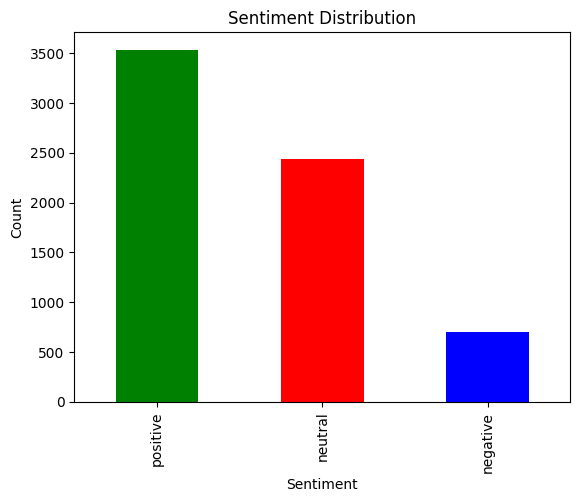

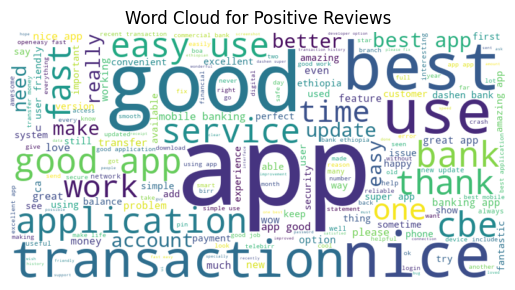

In [43]:
# Sentiment distribution
df['sentiment'].value_counts().plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Word cloud for positive reviews
positive_text = ' '.join(positive_reviews)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()

Sentiment Counts per Bank:

BOA => Positive: 282, Neutral: 308, Negative: 196
CBE => Positive: 2988, Neutral: 2054, Negative: 478
Dashen => Positive: 263, Neutral: 75, Negative: 25


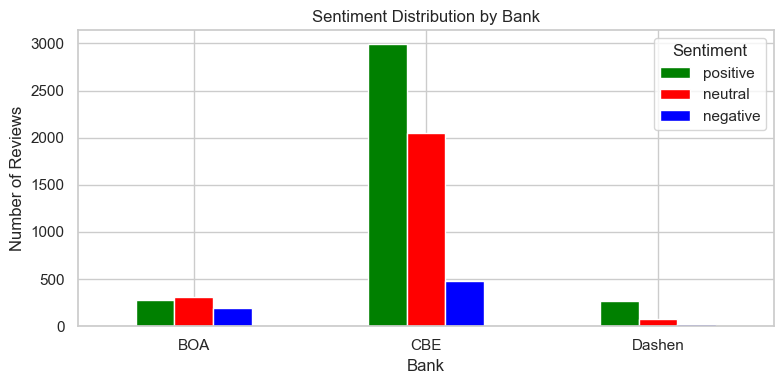

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set plot style
sns.set(style="whitegrid")

# Group by bank and sentiment, then count
sentiment_by_bank = df.groupby(['bank', 'sentiment']).size().unstack(fill_value=0)

# Rename columns for consistent order (optional)
sentiment_by_bank = sentiment_by_bank[['positive', 'neutral', 'negative']]

# Print sentiment counts per bank
print("Sentiment Counts per Bank:\n")
for bank in sentiment_by_bank.index:
    pos = sentiment_by_bank.loc[bank, 'positive']
    neu = sentiment_by_bank.loc[bank, 'neutral']
    neg = sentiment_by_bank.loc[bank, 'negative']
    print(f"{bank} => Positive: {pos}, Neutral: {neu}, Negative: {neg}")

# Plot as grouped bar chart
sentiment_by_bank.plot(kind='bar', 
                       figsize=(8, 4), 
                       color=['green', 'red', 'blue'])

plt.title('Sentiment Distribution by Bank')
plt.xlabel('Bank')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()


The image shows the sentiment distribution by bank, with the number of reviews for each bank broken down by negative, neutral, and positive sentiment. The key findings are:

**BOA**:
- Positive: 282
- Neutral: 308 
- Negative: 196

**CBE Bank**:
- Positive: 2988
- Neutral: 2054
- Negative: 478  

**Dashen Bank**:
- Positive: 263
- Neutral: 75
- Negative: 25

This data shows that CBE Bank has the highest number of positive reviews, followed by BOA and Dashen. CBE Bank also has the highest number of neutral and negative reviews compared to the other two banks.

The sentiment distribution indicates that CBE Bank has the most polarized reviews, with a large number of both positive and negative sentiments. In contrast, BOA and Dashen have a more balanced distribution of positive, neutral and negative reviews.

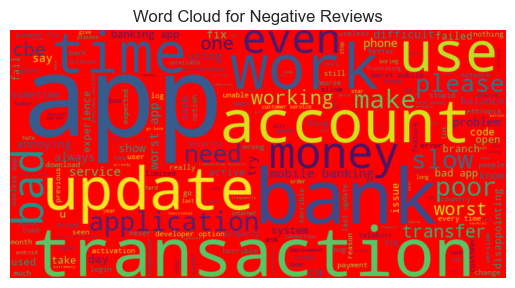

In [50]:
negative_text = ' '.join(negative_reviews)
wordcloud = WordCloud(width=800, height=400, background_color='red').generate(negative_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.show()